### Circumpolar Southern Ocean observational dataset over 18 years

~600,000 CTD hydrographic profiles from 45°S across the circumpolar Southern Ocean from 2004-2021, including Argo, MEOP, SOCCOM, and WOD18 data (ship-based CTD and gliders). Includes data only flagged as good and under ice.

Created by Theo Spira, Sebastiaan Swart and Marcel du Plessis

https://zenodo.org/records/10258138

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scipy
import cmocean
import math
import gsw
import matplotlib as mpl
import matplotlib.path as mpath
import warnings
from xgcm import Grid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imp

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, LatitudeLocator)
from shapely.geometry.polygon import LinearRing

%matplotlib inline

plt.rcParams['font.size'] = '12'

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

import src.calc as calc
import src.interpolation as interp
import src.settings as settings

In [4]:
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')

# Path to save figures
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')

In [5]:
# mean dynamic topography 
filename = 'dataset-mdt-hybrid-cnes-cls22-cmems2020-global_1710994188205.nc'
file = os.path.join(os.sep, datadir, 'altimetry', filename)

MDT = xr.open_dataset(file)

In [6]:
## mean position of ACC fronts based on Aviso fronts product 
## (https://www.aviso.altimetry.fr/en/data/products/value-added-products/acc-fronts-product.html)
## Sallee et al. (2008)
PF = -0.3
SAF = -0.1
nSAF = 0

In [7]:
# bathymetry
file1 = os.path.join(os.sep, datadir, 'bathy', 'gebco_2023_n-35.0_s-90.0_w0.0_e180.0.nc')
file2 = os.path.join(os.sep, datadir, 'bathy', 'gebco_2023_n-35.0_s-90.0_w-180.0_e0.0.nc')

bathymetry1 = xr.open_dataset(file1)
bathymetry2 = xr.open_dataset(file2)
bathymetry = xr.concat([bathymetry2, bathymetry1], dim = 'lon')

bathymetry['depth'] = bathymetry.elevation*-1
new_bathy = bathymetry.coarsen(lon=10).mean().coarsen(lat=10).mean()

In [8]:
file = os.path.join(os.sep, datadir, 'qc_profile_ds_2dbar.nc')
ds = xr.open_dataset(file, chunks = {})

In [65]:
year = 2005
n_years = 15

In [67]:
sel_t = ((ds.time.values >= np.datetime64(f'{year}-01-01')) & (ds.time.values < np.datetime64(f'{year+n_years}-01-01')))

In [68]:
sel_lat = (ds.lat.values < -35) & (ds.lat.values > -70)
sel = (sel_t) & (sel_lat)

In [69]:
print(f'no profiles: {len(np.where(sel)[0])}')

no profiles: 625406


In [14]:
# map_proj = ccrs.PlateCarree()
map_proj = ccrs.SouthPolarStereo()
geo = ccrs.Geodetic()

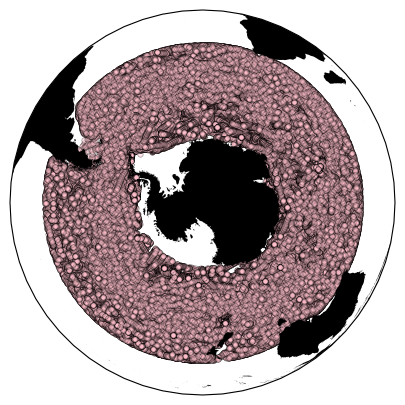

In [41]:
plt.figure(figsize=(12, 5))
ax = plt.axes(projection=map_proj)

ax.add_feature(land)

# transform lat/lons points to othographic points
points = map_proj.transform_points(geo, ds.lon[sel].values, ds.lat[sel].values)

ax.scatter(points[:, 0], points[:, 1], alpha = 0.4, s = 15, edgecolors = 'k', facecolors = 'pink', 
           linewidths = 0.5)

ax.set_global()

In [15]:
ds_chunks = ds.chunk(1000, 501)

In [16]:
# ds.close()
# del ds

In [17]:
mld = ds_chunks.mld.isel(n_prof = sel)

In [18]:
T = ds_chunks.temp.isel(n_prof = sel)
S = ds_chunks.psal.isel(n_prof = sel)
p = ds_chunks.pres

In [19]:
p2d = np.tile(p, (len(mld), 1))
mld2d = np.tile(mld, (len(p), 1)).transpose()

In [20]:
# remove mixed layer
T_interior = T.where((p2d > mld2d), np.nan)
S_interior = S.where((p2d > mld2d), np.nan)

In [152]:
i = 369649
S_smooth = S_interior.sel(n_prof = i).rolling(pres = 15, center = True, min_periods = 5).mean()

In [21]:
S = S_interior.copy()
T = T_interior.copy()

In [19]:
# fig, ax = plt.subplots(figsize = (4, 6))
# S_interior.sel(n_prof = i).plot(y = 'pres')
# S_smooth.plot(y = 'pres', c = 'grey', linestyle = '--')
# ax.invert_yaxis()

In [20]:
# ## smoothing filter 
# T_smooth = T_interior.rolling(pres = 15, center = True, min_periods = 5).mean().chunk(1000, 501)
# S_smooth = S_interior.rolling(pres = 15, center = True, min_periods = 5).mean().chunk(1000, 501)

# dens = calc.potentialDensity(p, S_smooth, T_smooth).chunk(1000, 501)

In [22]:
dens = calc.potentialDensity(p, S, T).chunk(1000, 501)

In [23]:
# First create an xgcm grid object
grid = Grid(ds_chunks, coords={'Z': {'center':'pres'}}, periodic=False)

dens_interval = 0.01
dens_grid = np.mgrid[np.nanmin(dens):np.nanmax(dens):dens_interval]

# transform to density
T_dens = grid.transform(T, 'Z', dens_grid, target_data=dens).rename({'psal': 'density'})
S_dens = grid.transform(S, 'Z', dens_grid, target_data=dens).rename({'psal': 'density'})
rho_dens = grid.transform(dens, 'Z', dens_grid, target_data=dens).rename({'psal': 'density'})

In [36]:
alpha = gsw.alpha(S, T, p)
alpha_dens = grid.transform(alpha, 'Z', dens_grid, target_data=dens).rename({'psal': 'density'})

In [37]:
def dsc(T_dens, rho_dens, alpha_dens):
    
    T_z = T_dens.differentiate('density')
    
    DSC = (2*alpha_dens*rho_dens*T_z.differentiate('density'))
    
    return DSC

In [38]:
DSC = dsc(T_dens, rho_dens, alpha_dens)

In [44]:
# settings.save_to_netCDF(DSC, datadir, 'dsc_circumpolar_2005_2020.nc')

In [8]:
file = os.path.join(os.sep, datadir, 'dsc_circumpolar_2005_2020.nc')
dsc = xr.open_dataset(file).__xarray_dataarray_variable__

### Depth-averaged DSC

In [46]:
mean_dsc = abs(DSC).mean(dim = 'density', skipna = True)
# mean_dsc = abs(dsc).sel(density = slice(27, 27.5)).mean(dim = 'density', skipna = True)

In [200]:
## dask to xarray
# mean_dsc = mean_dsc.compute()

In [48]:
# settings.save_to_netCDF(mean_dsc, datadir, 'mean_dsc_circumpolar_27.0to27.5.nc')
# settings.save_to_netCDF(mean_dsc, datadir, 'mean_dsc_circumpolar_MLD-1000dbar_2005-2020.nc')

saving to netcdf...


In [57]:
# mean_dsc.close()
# del mean_dsc

In [9]:
file1 = os.path.join(os.sep, datadir, 'mean_dsc_circumpolar.nc')
file2 = os.path.join(os.sep, datadir, 'mean_dsc_circumpolar_27.0to27.5.nc')
file3 = os.path.join(os.sep, datadir, 'mean_dsc_circumpolar_MLD-1000dbar_2005-2020.nc')
mean_dsc1 = xr.open_dataset(file1).__xarray_dataarray_variable__
mean_dsc2 = xr.open_dataset(file2).__xarray_dataarray_variable__
mean_dsc3 = xr.open_dataset(file3).__xarray_dataarray_variable__

### 1$^\circ$ lat lon bins

In [49]:
grid_size = 1
lon_bins = np.arange(-180, 185, grid_size)
lat_bins = np.arange(-70, -35, grid_size)

In [50]:
def bin_data(data, bins = [lon_bins, lat_bins], min_obs = 5):
    lon_bins, lat_bins = bins
    
    lon_mid = (lon_bins + np.gradient(lon_bins)/2)[:-1]
    lat_mid = (lat_bins + np.gradient(lat_bins)/2)[:-1]
    
    #remove nans
    data_nonan = data.where(~np.isnan(data), drop = True)
    
    # grid using scipy
    data_mean = scipy.stats.binned_statistic_2d(data_nonan.lon, data_nonan.lat, data_nonan, 
                                bins = [lon_bins, lat_bins], statistic='mean')[0]
    
    data_std = scipy.stats.binned_statistic_2d(data_nonan.lon, data_nonan.lat, data_nonan, 
                                bins = [lon_bins, lat_bins], statistic='std')[0]
    
    n_obs = scipy.stats.binned_statistic_2d(data_nonan.lon, data_nonan.lat, data_nonan, 
                                bins = [lon_bins, lat_bins], statistic='count')[0]
    
    # must have at least 5 observations per bin
    mask = np.ma.masked_where(n_obs < min_obs, n_obs)
    
    # to xarray
    data_mean = xr.DataArray(data_mean, dims = ['lon', 'lat'], coords = dict(lat = (['lat'], lat_mid), 
                                                                             lon = (['lon'], lon_mid)))
    
    data_std = xr.DataArray(data_std, dims = ['lon', 'lat'], coords = dict(lat = (['lat'], lat_mid), 
                                                                             lon = (['lon'], lon_mid)))
    
    n_obs = xr.DataArray(n_obs, dims = ['lon', 'lat'], coords = dict(lat = (['lat'], lat_mid), 
                                                                     lon = (['lon'], lon_mid)))
    
    data_mean.data[mask.mask] = np.nan
    data_std.data[mask.mask] = np.nan
    n_obs.data[mask.mask] = np.nan
    
    return data_mean, n_obs

In [51]:
def redbox(lonmin, lonmax, latmin, latmax):
    nvert = 100
    lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                np.linspace(lonmin, lonmax, nvert),
                np.linspace(lonmax, lonmax, nvert)].tolist()
    lats = np.r_[np.linspace(latmin, latmax, nvert),
                np.linspace(latmax, latmax, nvert),
                np.linspace(latmax, latmin, nvert)].tolist()
    
    ring = LinearRing(list(zip(lons, lats)))
    return ring

### Mean depth-averaged DSC in each grid cell

In [52]:
print(PF, nSAF)

-0.3 0


In [53]:
def mask_PFZ(griddata, MDT, limits = [PF, nSAF], pad = 0.1):
    PF, nSAF = limits
    
    # mask the PFZ for averaging
    mdt_interp = MDT.mdt[0].interp(latitude = griddata.lat, longitude = griddata.lon)
    mask1 = np.ma.masked_where((mdt_interp < PF-pad), mdt_interp)
    mask2 = np.ma.masked_where((mdt_interp > nSAF+pad), mdt_interp)

    grid_data_copy = griddata.transpose().copy()
    grid_data_copy.data[mask1.mask] = np.nan
    grid_data_copy.data[mask2.mask] = np.nan
    
    return grid_data_copy
    

In [54]:
def lon_0_to_360(data):
    neg_lon = np.where(data['lon'].data < 0)[0]
    data.lon.data[neg_lon] += 360
    return data.sortby('lon')

In [27]:
dsc_grid1 = bin_data(mean_dsc1, bins = [lon_bins, lat_bins])[0]
dsc_grid2, n_obs = bin_data(mean_dsc2, bins = [lon_bins, lat_bins])

In [37]:
grid_data1 = mask_PFZ(dsc_grid1, MDT, pad = 0.1)
mean_dsc_PFZ1 = grid_data1.mean(dim = 'lat').sel(lon = slice(-180,180))
mean_dsc_PFZ1 = lon_0_to_360(mean_dsc_PFZ1)

grid_data2 = mask_PFZ(dsc_grid2, MDT, pad = 0.1)
mean_dsc_PFZ2 = grid_data2.mean(dim = 'lat').sel(lon = slice(-180,180))
mean_dsc_PFZ2 = lon_0_to_360(mean_dsc_PFZ2)

Text(0.5, 1.0, 'Observations: PFZ, $\\rho$ = 27.0$-$27.5, t = 2010-2020')

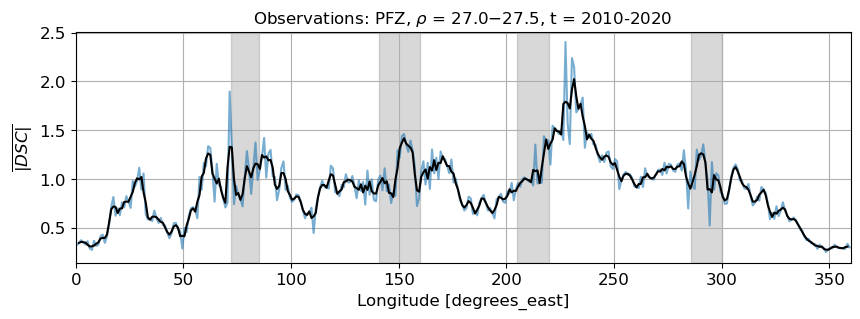

In [46]:
fig, ax = plt.subplots(figsize = (10,3))
mean_dsc_PFZ2.plot(alpha = 0.6)
mean_dsc_PFZ2.rolling(lon = 3, center = True).mean().plot(c='k')
ax.axvspan(xmin = 141, xmax = 160, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 205, xmax = 220, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 286, xmax = 300, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 72, xmax = 85, color = 'grey', alpha = 0.3)
plt.ylabel(r'$\overline{|DSC|}$')
plt.grid()
plt.xlim(0, 360)
plt.xlabel('Longitude [degrees_east]')
plt.title(r'Observations: PFZ, $\rho$ = 27.0$-$27.5, t = 2005-2020', fontsize = 12)

Text(0.5, 1.0, 'Observations: PFZ, t = 2010-2020')

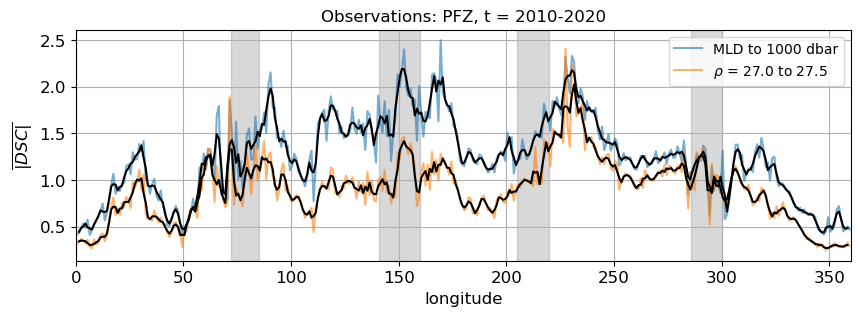

In [50]:
fig, ax = plt.subplots(figsize = (10,3))
mean_dsc_PFZ1.plot(alpha = 0.6)
mean_dsc_PFZ2.plot(alpha = 0.6)
plt.legend(['MLD to 1000 dbar', r'$\rho$ = 27.0 to 27.5'], fontsize = 10)
mean_dsc_PFZ1.rolling(lon = 3, center = True).mean().plot(c='k')
mean_dsc_PFZ2.rolling(lon = 3, center = True).mean().plot(c='k')
ax.axvspan(xmin = 141, xmax = 160, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 205, xmax = 220, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 286, xmax = 300, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 72, xmax = 85, color = 'grey', alpha = 0.3)
plt.ylabel(r'$\overline{|DSC|}$')
plt.grid()
plt.xlim(0, 360)
plt.xlabel('longitude')
plt.title(r'Observations: PFZ, t = 2005-2020', fontsize = 12)
# plt.title(r'Obs: PFZ, MLD to 1000 dbar, t = 2005-2020', fontsize = 12)
# plt.title(r'Obs: PFZ, $\rho$ = 27.0$-$27.5, t = 2005-2020', fontsize = 12)

In [52]:
dsc_sel1 = abs(dsc).sel(density = 27.1, method = 'nearest')
dsc_sel2 = abs(dsc).sel(density = 27.4, method = 'nearest')

dsc_grid1 = bin_data(dsc_sel1, bins = [lon_bins, lat_bins])[0]
dsc_grid2 = bin_data(dsc_sel2, bins = [lon_bins, lat_bins])[0]

In [53]:
grid_data1 = mask_PFZ(dsc_grid1, MDT)
grid_data2 = mask_PFZ(dsc_grid2, MDT)

In [54]:
mean_dsc_PFZ1 = lon_0_to_360(grid_data1.mean(dim = 'lat').sel(lon = slice(-180,180)))
mean_dsc_PFZ2 = lon_0_to_360(grid_data2.mean(dim = 'lat').sel(lon = slice(-180,180)))

Text(0.5, 1.0, 'Obs: PFZ, t = 2010-2020')

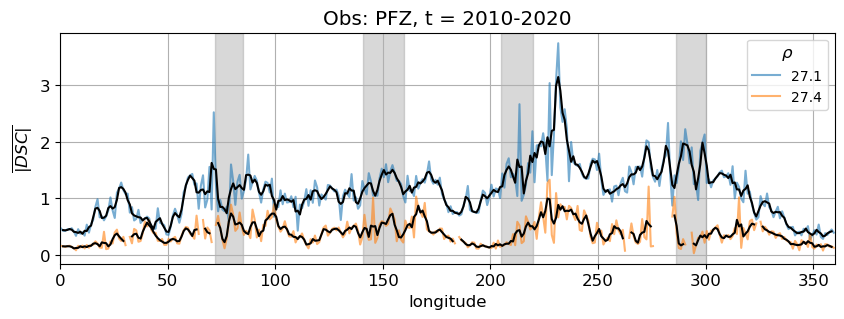

In [55]:
fig, ax = plt.subplots(figsize = (10,3))
mean_dsc_PFZ1.plot(alpha = 0.6)
mean_dsc_PFZ2.plot(alpha = 0.6)
plt.legend([27.1, 27.4], title = r'$\rho$', fontsize = 10)
mean_dsc_PFZ1.rolling(lon = 3, center = True).mean().plot(c='k')
mean_dsc_PFZ2.rolling(lon = 3, center = True).mean().plot(c='k')
ax.axvspan(xmin = 141, xmax = 160, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 205, xmax = 220, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 286, xmax = 300, color = 'grey', alpha = 0.3)
ax.axvspan(xmin = 72, xmax = 85, color = 'grey', alpha = 0.3)
plt.ylabel(r'$\overline{|DSC|}$')
plt.grid()
plt.xlim(0, 360)
plt.xlabel('longitude')
plt.title(r'Obs: PFZ, t = 2005-2020')

In [55]:
def plot_circumpolar(grid_data, bathy, MDT, extent = [-180, 180, -90, -36], cbar_label = '', mask = False, **kwargs):
    
    PF = -0.3
    nSAF = 0
    
    fig = plt.figure(figsize=(12, 5))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor= None, facecolor='k')

    ax.add_feature(land)
    ax.set_extent(extent, ccrs.PlateCarree())

    gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6,
                    color='gray', alpha=0.6, zorder=10, xlocs=range(-180,180,30))

    gls.xlabel_style = {'size': 10, 'color': 'k'}
    gls.ylabel_style = {'size': 0, 'color': 'k'}

    r_extent = 6521311
    r_extent *= 1.005  

    # set the plot limits
    ax.set_xlim(-r_extent, r_extent)
    ax.set_ylim(-r_extent, r_extent)

    # Prep circular boundary
    circle_path = mpath.Path.unit_circle()
    circle_path = mpath.Path(circle_path.vertices.copy() * r_extent,
                               circle_path.codes.copy())

    #set circular boundary
    ax.set_boundary(circle_path)

    # draw longitude labels
    plt.draw() 

    # Reposition the meridian tick labels
    for ea in gls._labels:
        pos = ea[2].get_position()
        if (pos[0]==150):
            ea[2].set_position([180, pos[1]])

    #plot DSC
    if mask == True:
        grid_data_copy = mask_PFZ(grid_data, MDT)
        grid_data.transpose().plot(ax = ax, transform = ccrs.PlateCarree(), alpha = 0.5, add_colorbar = False, **kwargs)

        im = grid_data_copy.plot(ax = ax, transform = ccrs.PlateCarree(),
                          cbar_kwargs = dict(label = cbar_label), **kwargs)
        
    else:
        im = grid_data.transpose().plot(ax = ax, transform = ccrs.PlateCarree(),
                                  cbar_kwargs = dict(label = cbar_label), **kwargs)

    #bathymetry
    bathy.depth.plot.contour(ax = ax, levels = [1500], colors = 'silver', linewidths = 0.8, transform = ccrs.PlateCarree())

    # plot ACC fronts
    MDT.mdt[0].plot.contour(ax = ax, levels = [PF], colors = 'k', linestyles = '-', linewidths = 1.2, alpha = 0.8,
                            transform = ccrs.PlateCarree())
    MDT.mdt[0].plot.contour(ax = ax, levels = [nSAF], colors = 'k', linestyles = '--', linewidths = 1.2, alpha = 0.8,
                            transform = ccrs.PlateCarree())

    plt.tight_layout()
    plt.title('')
    
    return fig, ax
    

In [56]:
dsc_label = '$\overline{|DSC|}$ (m$^{3}$ kg$^{-1}$)'

In [57]:
dsc_grid, n_obs = bin_data(mean_dsc, bins = [lon_bins, lat_bins])

Text(0.5, 1.0, 't = 2005$-$2020, MLD-1000 dbar')

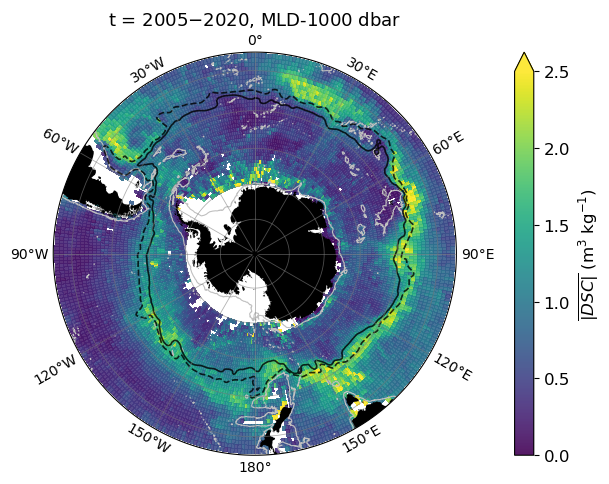

In [62]:
# average from MLD to 1000 dbar 
fig, ax = plot_circumpolar(dsc_grid, new_bathy, MDT, vmin = 0, vmax = 2.5, alpha = 0.9, cbar_label = dsc_label, mask = False)
ax.set_title('t = 2005$-$2020, MLD-1000 dbar', fontsize = 13)

In [63]:
# settings.save_figure(fig, my_path, 'cirucmpolar_dsc_below_ML_2005-2020.png', dpi = 600, pad = 0.2)

In [73]:
np.nanmax(n_obs)

1732.0

Text(0.5, 1.0, 't = 2005$-$2020 \n$\\rho$ = 27.0-27.5 kg m$^{-3}$')

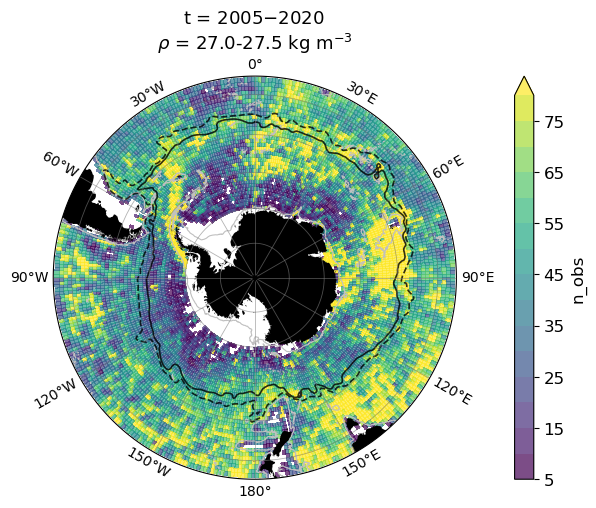

In [60]:
fig, ax = plot_circumpolar(n_obs, new_bathy, MDT, cbar_label = 'n_obs', alpha = 0.7, 
                           cmap = 'viridis', levels = np.arange(5, 85, 5))

ax.set_title('t = 2005$-$2020 \n' + r'$\rho$ = 27.0-27.5 kg m$^{-3}$', fontsize = 13)

Text(0.5, 1.0, 't = 2010$-$2020 \n$\\rho$ = 27.0-27.5 kg m$^{-3}$')

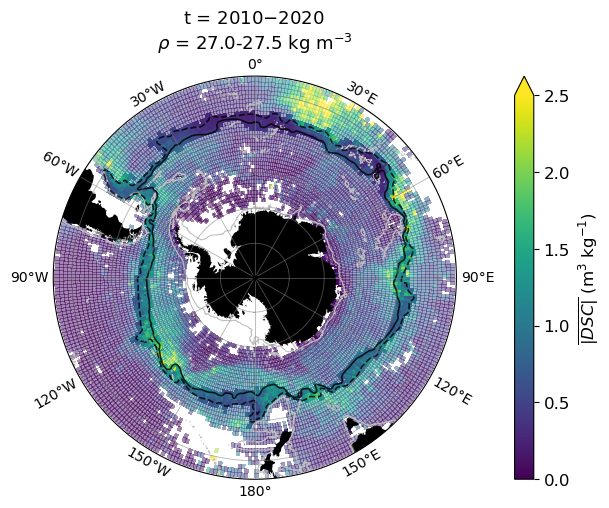

In [45]:
# average from 27.0 to 27.5
fig, ax = plot_circumpolar(dsc_grid2, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label, mask = True)
ax.set_title('t = 2010$-$2020 \n' + r'$\rho$ = 27.0-27.5 kg m$^{-3}$', fontsize = 13)

Text(0.5, 1.0, 't = 2010$-$2020 \n$\\rho$ = 27.0-27.5 kg m$^{-3}$')

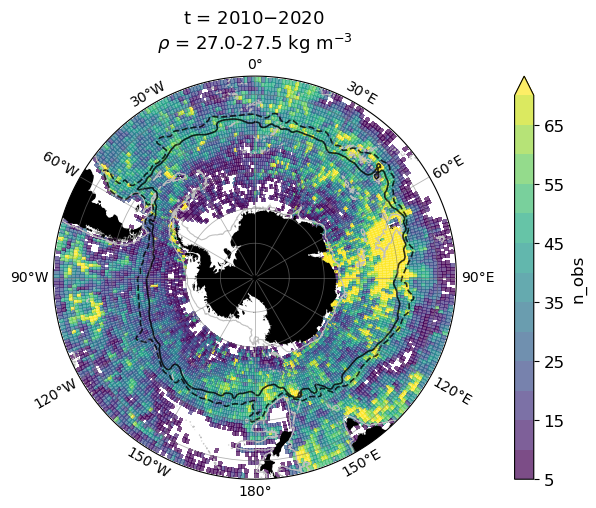

In [48]:
fig, ax = plot_circumpolar(n_obs, new_bathy, MDT, cbar_label = 'n_obs', alpha = 0.7, 
                           cmap = 'viridis', levels = np.arange(5, 75, 5))

ax.set_title('t = 2010$-$2020 \n' + r'$\rho$ = 27.0-27.5 kg m$^{-3}$', fontsize = 13)

Text(0.5, 1.0, 'MLD to 1000 dbar')

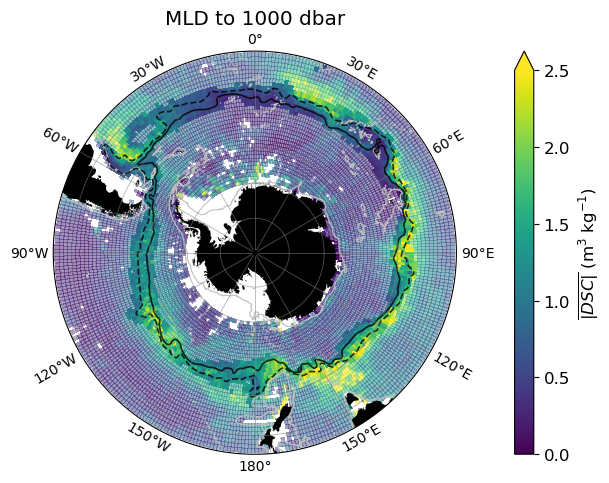

In [63]:
fig, ax = plot_circumpolar(dsc_grid, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label, mask = True)
ax.set_title('MLD to 1000 dbar')

In [167]:
# settings.save_figure(fig, my_path, 'cirucmpolar_dsc_below_ML.png', dpi = 600, pad = 0.2)

Text(0.5, 1.0, '$\\rho$ = 27.1 kg m$^{-3}$')

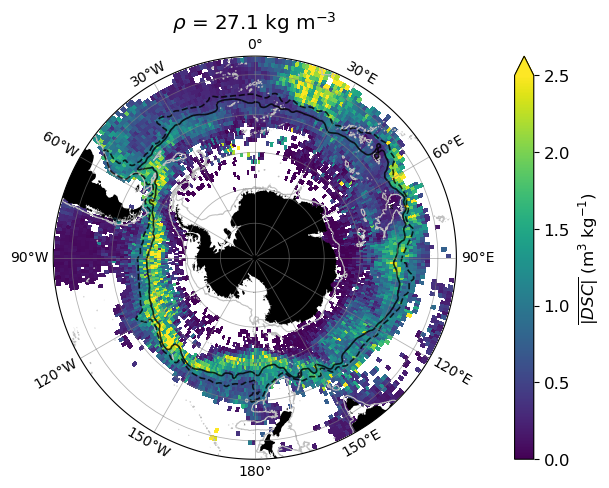

In [106]:
fig, ax = plot_circumpolar(dsc_grid1, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label)
ax.set_title(r'$\rho$ = 27.1 kg m$^{-3}$')

Text(0.5, 1.0, '$\\rho$ = 27.4 kg m$^{-3}$')

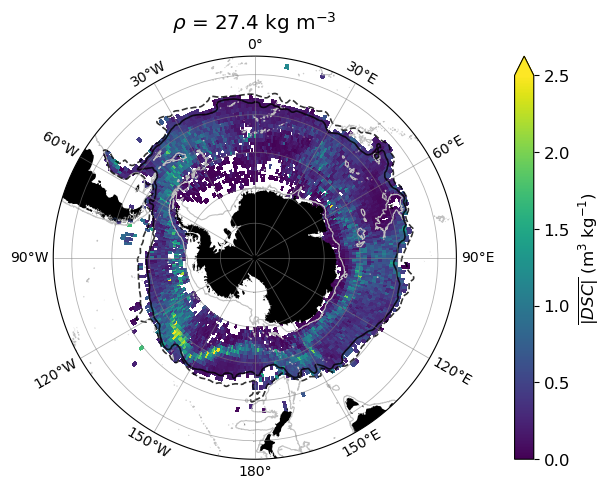

In [107]:
fig, ax = plot_circumpolar(dsc_grid2, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label)
ax.set_title(r'$\rho$ = 27.4 kg m$^{-3}$')

### Standard deviation in each grid cell

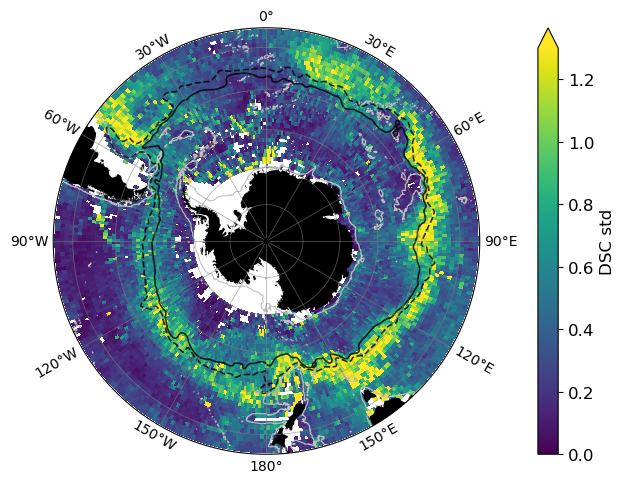

In [168]:
plot_circumpolar(dsc_std, new_bathy, MDT, vmin = 0, vmax = 1.3, cbar_label = 'DSC std')

### Number of profiles per grid cell 

<GeoAxesSubplot:xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

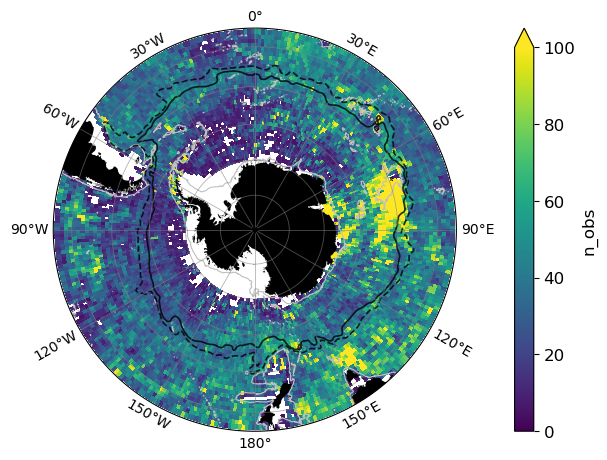

In [313]:
plot_circumpolar(n_obs_grid, new_bathy, MDT, vmin = 0, vmax = 100, cbar_label = 'n_obs')

### Drake Passage

In [189]:
DP_dsc = dsc_grid.sel(lat = slice(-70, -50), lon = slice(-90, -30))

Text(0.5, 1.0, '')

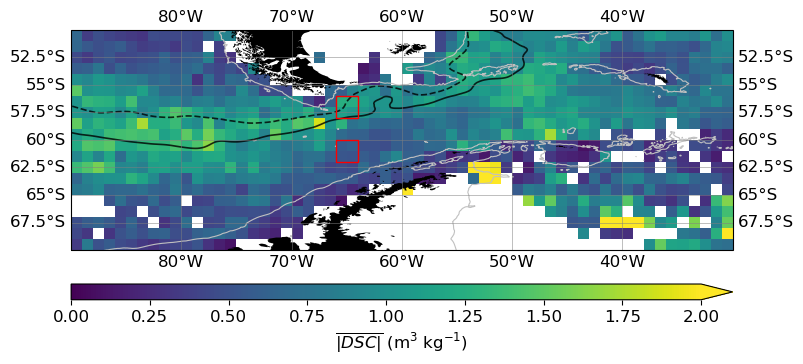

In [296]:
fig = plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor= None,
                                        facecolor='k')

ax.add_feature(land)
ax.set_extent([-90, -30, -70, -50], ccrs.PlateCarree())

gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6,
                    color='gray', alpha=0.6)

DP_dsc.plot(ax = ax, x = 'lon', vmin = 0, vmax = 2, cbar_kwargs = dict(label = dsc_label, 
                                                                         orientation = 'horizontal', 
                                                                         pad = 0.1, 
                                                                         aspect = 40))


#bathymetry
new_bathy.depth.plot.contour(ax = ax, levels = [1500], colors = 'silver', linewidths = 0.8, transform = ccrs.PlateCarree())

# plot ACC fronts
MDT.mdt[0].plot.contour(ax = ax, levels = [PF], colors = 'k', linestyles = '-', linewidths = 1.2, alpha = 0.8,
                        transform = ccrs.PlateCarree())
MDT.mdt[0].plot.contour(ax = ax, levels = [nSAF], colors = 'k', linestyles = '--', linewidths = 1.2, alpha = 0.8,
                        transform = ccrs.PlateCarree())


# Antarctic zone
latmin, latmax = -60, -62 
lonmin, lonmax = -66, -64
box1 = redbox(lonmin, lonmax, latmin, latmax)

# Polar Front zone
latmin, latmax = -58, -56
box2 = redbox(lonmin, lonmax, latmin, latmax)

ax.add_geometries([box1], ccrs.PlateCarree(),
                facecolor='none', edgecolor='red', linewidth=1, zorder = 5)

ax.add_geometries([box2], ccrs.PlateCarree(),
                facecolor='none', edgecolor='red', linewidth=1, zorder = 5)


plt.tight_layout()

plt.title('')

In [297]:
latmin, latmax = -62, -60 
lonmin, lonmax = -66, -64

mask = ((DSC.coords["lon"] > lonmin) & (DSC.coords["lon"] < lonmax) & 
        (DSC.coords["lat"] > latmin) & (DSC.coords["lat"] < latmax))

dsc_sel = DSC.where(mask, drop = True).compute()
T_sel = T_dens.where(mask, drop = True).compute()
S_sel = S_dens.where(mask, drop = True).compute()

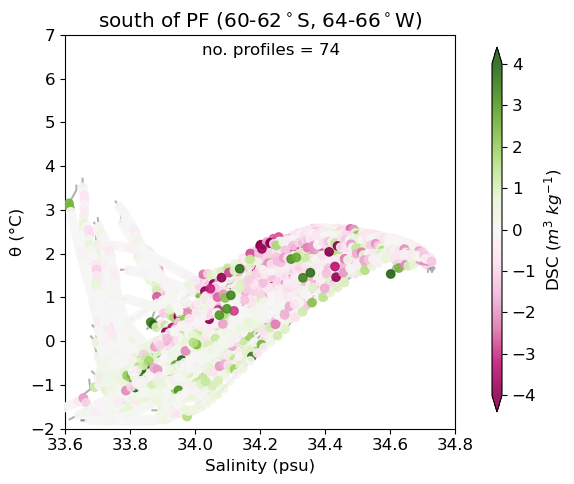

In [298]:
s, t, c = S_sel, T_sel, dsc_sel

fig, ax = plt.subplots(figsize= (5,5))

for i in range(len(c)):
    plt.plot(s[i], t[i], c = 'grey', alpha = 0.6)
    im = plt.scatter(s[i], t[i], c = c[i], cmap = 'PiYG', alpha = 0.9, vmin = -4, vmax = 4, zorder = 5)

ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')

ax.set_xlim(33.6, 34.8)
ax.set_ylim(-2, 7)

ax.text(0.35, 0.95 , f'no. profiles = {len(t)}', transform = ax.transAxes)
plt.title(f'south of PF ({abs(latmax)}-{abs(latmin)}$^\circ$S, {abs(lonmax)}-{abs(lonmin)}$^\circ$W)')

plt.tight_layout()

cax = plt.axes([1, 0.16, 0.02, 0.73])
plt.colorbar(im, cax = cax, label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

In [299]:
T_sel_on_p = T.where(mask, drop = True).compute()
S_sel_on_p = S.where(mask, drop = True).compute()

Text(0, 0.5, '')

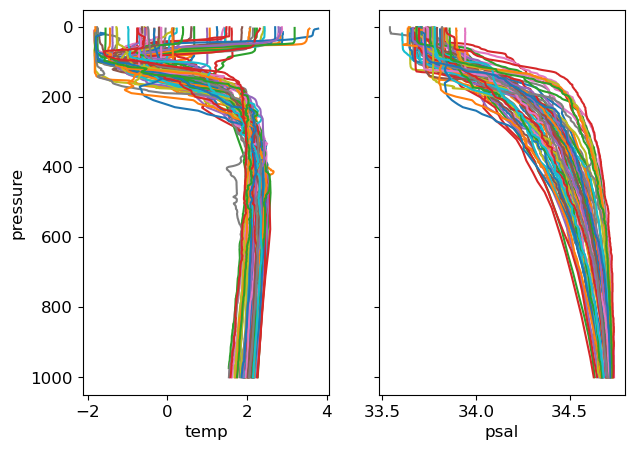

In [300]:
t, s = T_sel_on_p, S_sel_on_p

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize= (7,5))

for i in range(len(t)):
    t[i].plot(ax = ax1, y = 'pres')
    s[i].plot(ax = ax2, y = 'pres')

ax1.invert_yaxis()
ax1.set_title('')
ax1.set_ylabel('pressure')

ax2.set_title('')
ax2.set_ylabel('')

In [301]:
## Polar Front zone
latmin, latmax = -58, -56
lonmin, lonmax = -66, -64

mask = ((DSC.coords["lon"] > lonmin) & (DSC.coords["lon"] < lonmax) & 
        (DSC.coords["lat"] > latmin) & (DSC.coords["lat"] < latmax))

# subset then convert dask to xarray
dsc_sel = DSC.where(mask, drop = True).compute()
T_sel = T_dens.where(mask, drop = True).compute()
S_sel = S_dens.where(mask, drop = True).compute()

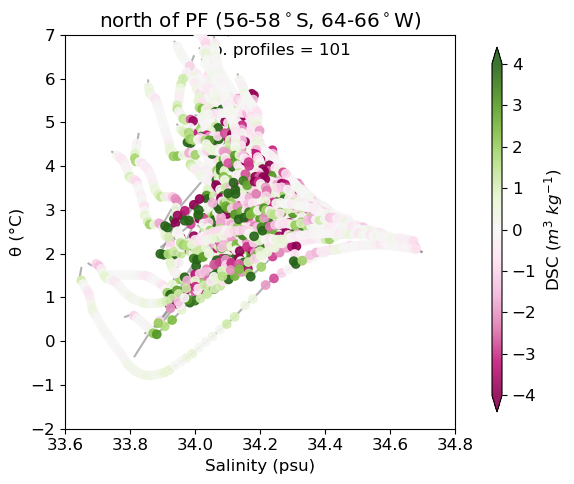

In [302]:
s, t, c = S_sel, T_sel, dsc_sel

fig, ax = plt.subplots(figsize= (5,5))

for i in range(len(c)):
    plt.plot(s[i], t[i], c = 'grey', alpha = 0.6)
    im = plt.scatter(s[i], t[i], c = c[i], cmap = 'PiYG', alpha = 0.9, vmin = -4, vmax = 4, zorder = 5)

ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')

ax.set_xlim(33.6, 34.8)
ax.set_ylim(-2, 7)

ax.text(0.35, 0.95 , f'no. profiles = {len(t)}', transform = ax.transAxes)
plt.title(f'north of PF ({abs(latmax)}-{abs(latmin)}$^\circ$S, {abs(lonmax)}-{abs(lonmin)}$^\circ$W)')

plt.tight_layout()

cax = plt.axes([1, 0.16, 0.02, 0.73])
plt.colorbar(im, cax = cax, label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

In [303]:
T_sel_on_p = T.where(mask, drop = True).compute()
S_sel_on_p = S.where(mask, drop = True).compute()

Text(0, 0.5, '')

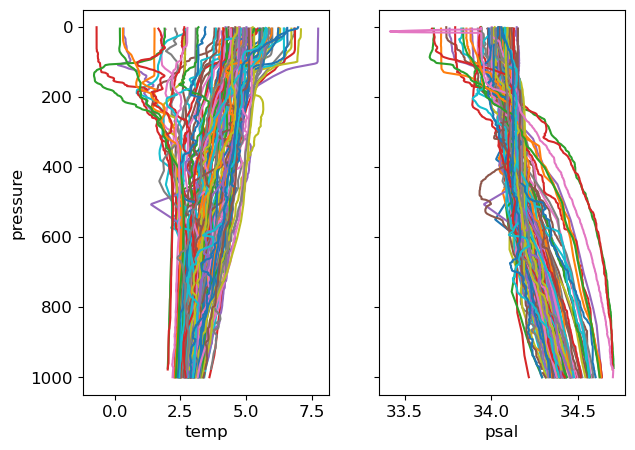

In [304]:
t, s = T_sel_on_p, S_sel_on_p

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize= (7,5))

for i in range(len(t)):
    t[i].plot(ax = ax1, y = 'pres')
    s[i].plot(ax = ax2, y = 'pres')

ax1.invert_yaxis()
ax1.set_title('')
ax1.set_ylabel('pressure')

ax2.set_title('')
ax2.set_ylabel('')

### Group into seasons

In [71]:
dsc_sel_group = dsc_sel.groupby('time.season')
T_sel_group = T_sel.groupby('time.season')
S_sel_group = S_sel.groupby('time.season')

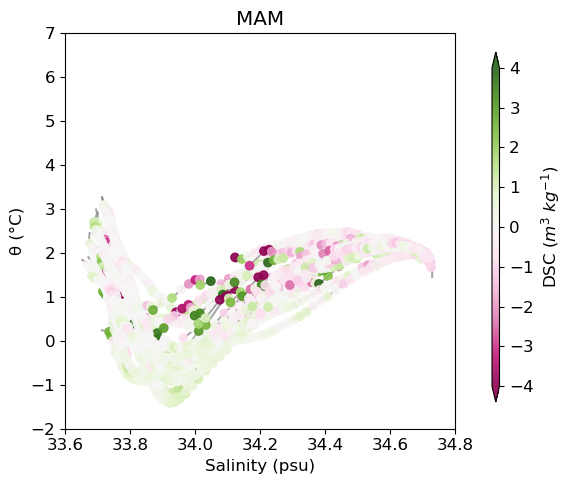

In [72]:
season = 'MAM'

s, t, c = S_sel_group[season].compute(), T_sel_group[season], dsc_sel_group[season]

fig, ax = plt.subplots(figsize= (5,5))

for i in range(len(c)):
    plt.plot(s[i], t[i], c = 'grey', alpha = 0.7)
    im = plt.scatter(s[i], t[i], c = c[i], cmap = 'PiYG', alpha = 0.9, vmin = -4, vmax = 4, zorder = 5)

ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')

ax.set_xlim(33.6, 34.8)
ax.set_ylim(-2, 7)
plt.title(season)

plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.18, 0.015, 0.7])
plt.colorbar(im, cax = cax, label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

In [ ]:
# spring
season = 'SON'

s, t, c = S_sel_group[season], T_sel_group[season], dsc_sel_group[season]

fig, ax = plt.subplots(figsize= (5,5))

for i in range(len(c)):
    plt.plot(s[i], t[i], c = 'grey', alpha = 0.7)
    im = plt.scatter(s[i], t[i], c = c[i], cmap = 'PiYG', alpha = 0.9, vmin = -4, vmax = 4, zorder = 5)

ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')

ax.set_xlim(33.6, 34.8)
ax.set_ylim(-2, 7)
plt.title(season)

plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.18, 0.015, 0.7])
plt.colorbar(im, cax = cax, label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

### Southeast Indian Ridge / Macquarie Ridge

In [267]:
MR_dsc = dsc_grid.sel(lat = slice(-70, -50), lon = slice(120, 180))

Text(0.5, 1.0, '')

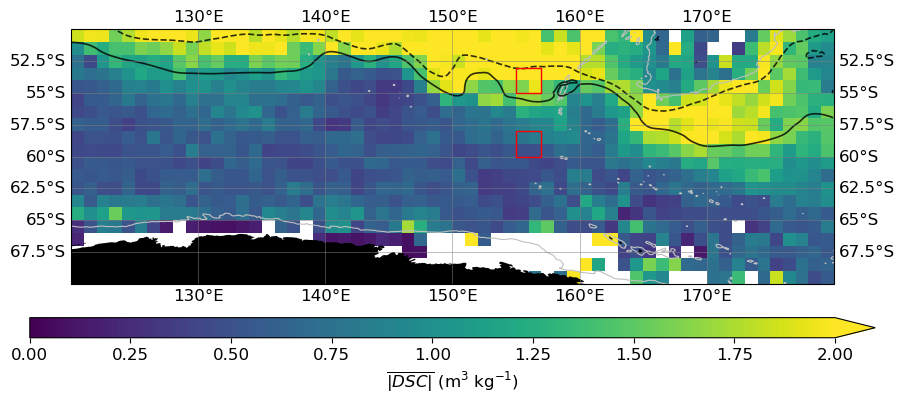

In [295]:
fig = plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor= None,
                                        facecolor='k')

ax.add_feature(land)
ax.set_extent([120, 180, -70, -50], ccrs.PlateCarree())

gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6,
                    color='gray', alpha=0.6)

MR_dsc.plot(ax = ax, x = 'lon', vmin = 0, vmax = 2, cbar_kwargs = dict(label = dsc_label, 
                                                                         orientation = 'horizontal', 
                                                                         pad = 0.1, 
                                                                         aspect = 40))


#bathymetry
new_bathy.depth.plot.contour(ax = ax, levels = [1500], colors = 'silver', linewidths = 0.8, transform = ccrs.PlateCarree())

# plot ACC fronts
MDT.mdt[0].plot.contour(ax = ax, levels = [PF], colors = 'k', linestyles = '-', linewidths = 1.2, alpha = 0.8,
                        transform = ccrs.PlateCarree())
MDT.mdt[0].plot.contour(ax = ax, levels = [nSAF], colors = 'k', linestyles = '--', linewidths = 1.2, alpha = 0.8,
                        transform = ccrs.PlateCarree())


# Antarctic zone
latmin, latmax = -58, -60
lonmin, lonmax = 155, 157
box1 = redbox(lonmin, lonmax, latmin, latmax)

# Polar Front zone
latmin, latmax = -55, -53
box2 = redbox(lonmin, lonmax, latmin, latmax)

ax.add_geometries([box1], ccrs.PlateCarree(),
                facecolor='none', edgecolor='red', linewidth=1, zorder = 5)

ax.add_geometries([box2], ccrs.PlateCarree(),
                facecolor='none', edgecolor='red', linewidth=1, zorder = 5)


plt.tight_layout()

plt.title('')

In [279]:
## Antarctic zone
latmin, latmax = -60, -58
lonmin, lonmax = 155, 157

mask = ((DSC.coords["lon"] > lonmin) & (DSC.coords["lon"] < lonmax) & 
        (DSC.coords["lat"] > latmin) & (DSC.coords["lat"] < latmax))

# subset then convert dask to xarray
dsc_sel = DSC.where(mask, drop = True).compute()
T_sel = T_dens.where(mask, drop = True).compute()
S_sel = S_dens.where(mask, drop = True).compute()

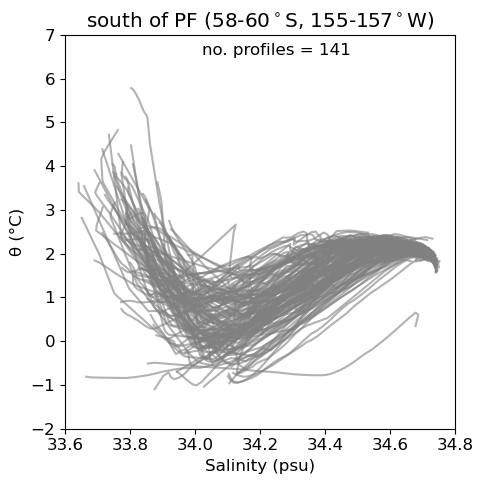

In [283]:
s, t, c = S_sel, T_sel, dsc_sel

fig, ax = plt.subplots(figsize= (5,5))

for i in range(len(c)):
    plt.plot(s[i], t[i], c = 'grey', alpha = 0.6)
#     im = plt.scatter(s[i], t[i], c = c[i], cmap = 'PiYG', alpha = 0.9, vmin = -4, vmax = 4, zorder = 5)

ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')

ax.set_xlim(33.6, 34.8)
ax.set_ylim(-2, 7)

ax.text(0.35, 0.95 , f'no. profiles = {len(t)}', transform = ax.transAxes)
plt.title(f'south of PF ({abs(latmax)}-{abs(latmin)}$^\circ$S, {abs(lonmin)}-{abs(lonmax)}$^\circ$W)')

plt.tight_layout()

# cax = plt.axes([1, 0.16, 0.02, 0.73])
# plt.colorbar(im, cax = cax, label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

In [284]:
T_sel_on_p = T.where(mask, drop = True).compute()
S_sel_on_p = S.where(mask, drop = True).compute()

Text(0, 0.5, '')

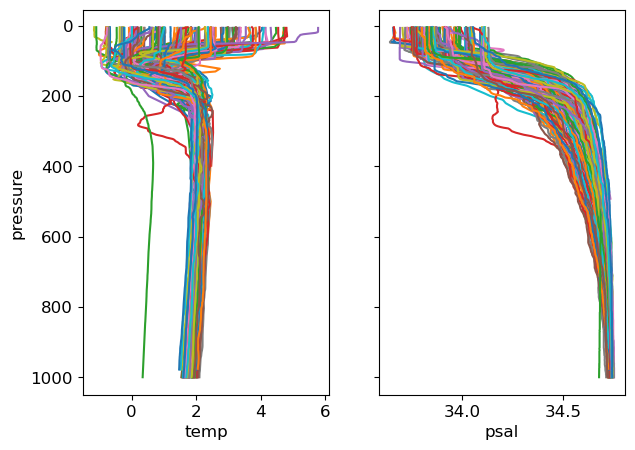

In [285]:
t, s = T_sel_on_p, S_sel_on_p

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize= (7,5))

for i in range(len(t)):
    t[i].plot(ax = ax1, y = 'pres')
    s[i].plot(ax = ax2, y = 'pres')

ax1.invert_yaxis()
ax1.set_title('')
ax1.set_ylabel('pressure')

ax2.set_title('')
ax2.set_ylabel('')

In [286]:
## Polar Front zone
latmin, latmax = -55, -53
lonmin, lonmax = 155, 157

mask = ((DSC.coords["lon"] > lonmin) & (DSC.coords["lon"] < lonmax) & 
        (DSC.coords["lat"] > latmin) & (DSC.coords["lat"] < latmax))

# subset then convert dask to xarray
dsc_sel = DSC.where(mask, drop = True).compute()
T_sel = T_dens.where(mask, drop = True).compute()
S_sel = S_dens.where(mask, drop = True).compute()

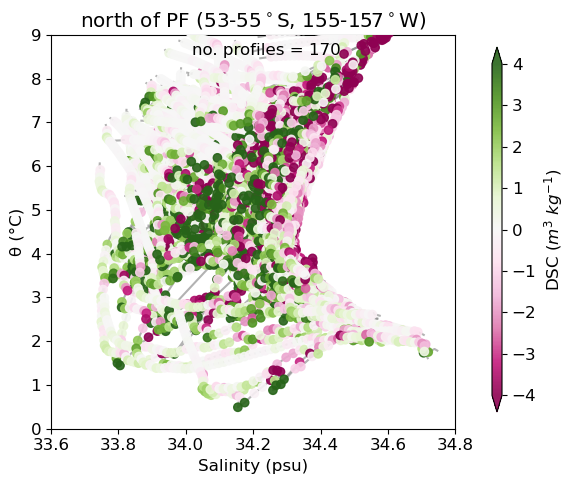

In [292]:
s, t, c = S_sel, T_sel, dsc_sel

fig, ax = plt.subplots(figsize= (5,5))

for i in range(len(c)):
    plt.plot(s[i], t[i], c = 'grey', alpha = 0.6)
    im = plt.scatter(s[i], t[i], c = c[i], cmap = 'PiYG', alpha = 0.9, vmin = -4, vmax = 4, zorder = 5)

ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')

ax.set_xlim(33.6, 34.8)
ax.set_ylim(0, 9)

ax.text(0.35, 0.95 , f'no. profiles = {len(t)}', transform = ax.transAxes, zorder = 8)
plt.title(f'north of PF ({abs(latmax)}-{abs(latmin)}$^\circ$S, {abs(lonmin)}-{abs(lonmax)}$^\circ$W)')

plt.tight_layout()

cax = plt.axes([1, 0.16, 0.02, 0.73])
plt.colorbar(im, cax = cax, label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

In [293]:
T_sel_on_p = T.where(mask, drop = True).compute()
S_sel_on_p = S.where(mask, drop = True).compute()

Text(0, 0.5, '')

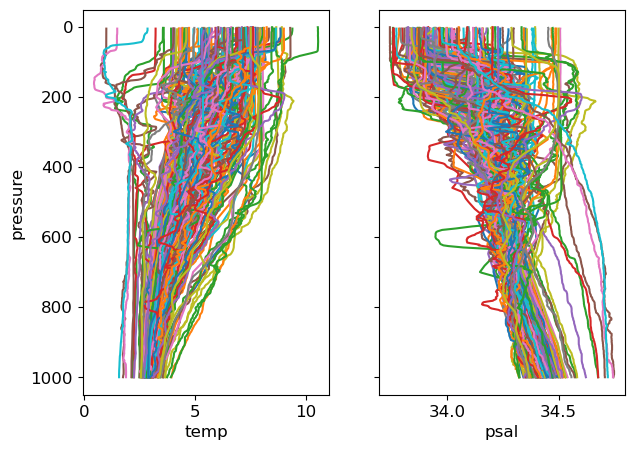

In [294]:
t, s = T_sel_on_p, S_sel_on_p

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize= (7,5))

for i in range(len(t)):
    t[i].plot(ax = ax1, y = 'pres')
    s[i].plot(ax = ax2, y = 'pres')

ax1.invert_yaxis()
ax1.set_title('')
ax1.set_ylabel('pressure')

ax2.set_title('')
ax2.set_ylabel('')

In [360]:
# settings.save_figure(fig, my_path, 'circumpolar_dsc.png', dpi = 600, pad = 0.2)

### Group by month/season

In [97]:
def depth_avg(x):
    return abs(x).mean(dim='density', skipna = True)

In [98]:
dsc_avg = DSC.groupby('time.month').apply(depth_avg)
avg_dsc_bymonth = dsc_avg.groupby('time.month').map(np.mean)

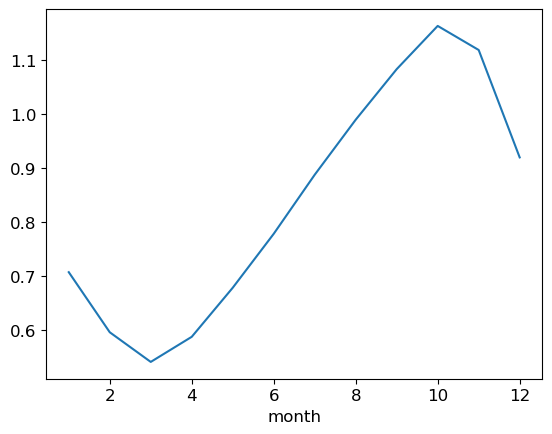

In [99]:
avg_dsc_bymonth.plot()

In [178]:
gb = mean_dsc.groupby('time.season')
gb

Text(0.5, 1.0, 'summer (DJF)')

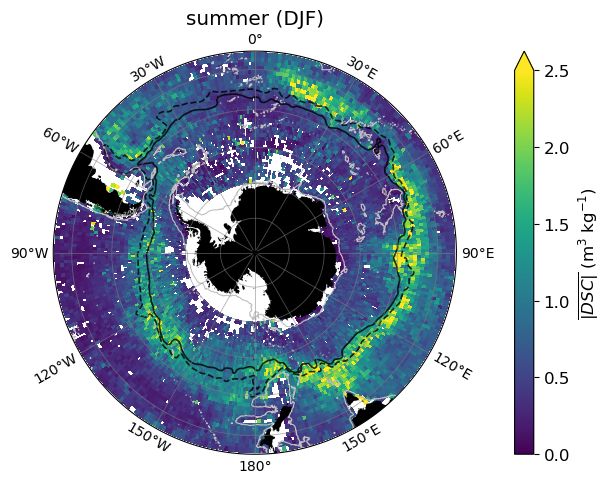

In [188]:
#summer
dsc_grid_DJF = bin_data(gb['DJF'], bins = [lon_bins, lat_bins],  min_obs = 1)[0]
ax = plot_circumpolar(dsc_grid_DJF, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label)
ax.set_title('summer (DJF)')
plt.show()

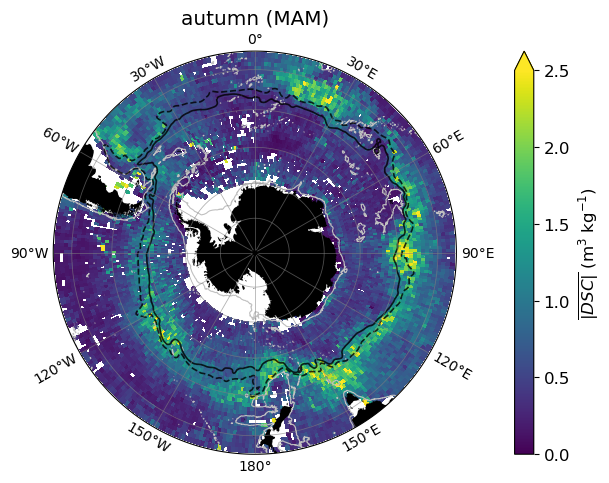

In [189]:
# autumn
dsc_grid_MAM = bin_data(gb['MAM'], bins = [lon_bins, lat_bins],  min_obs = 1)[0]
ax = plot_circumpolar(dsc_grid_MAM, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label)
ax.set_title('autumn (MAM)')
plt.show()

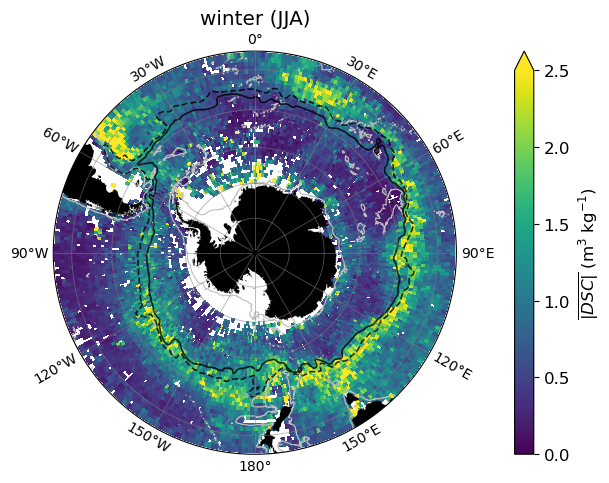

In [186]:
# winter
dsc_grid_JJA = bin_data(gb['JJA'], bins = [lon_bins, lat_bins],  min_obs = 1)[0]
ax = plot_circumpolar(dsc_grid_JJA, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label)
ax.set_title('winter (JJA)')
plt.show()

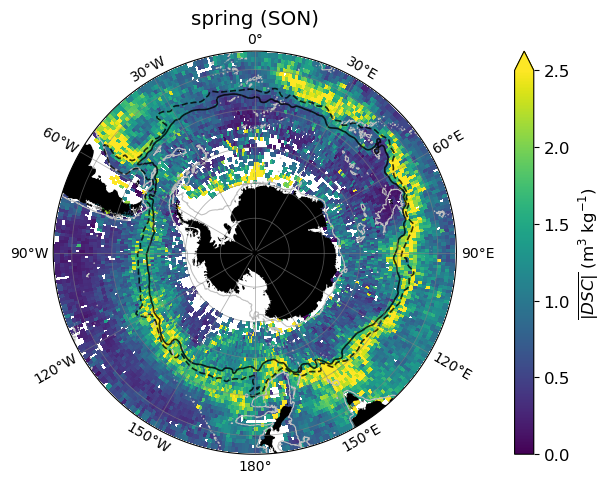

In [187]:
# spring 
dsc_grid_SON = bin_data(gb['SON'], bins = [lon_bins, lat_bins],  min_obs = 1)[0]
ax = plot_circumpolar(dsc_grid_SON, new_bathy, MDT, vmin = 0, vmax = 2.5, cbar_label = dsc_label)
ax.set_title('spring (SON)')
plt.show()